<a href="https://colab.research.google.com/github/dheerajreddy2020/Dog-Breed-identification/blob/master/Copy_of_Dog_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## End to End Multiclass dog breed classification
This notebook builds end to end multiclass image classification using tensorflow hub

## Problem:
Identifying a dog breed

## Data:
https://www.kaggle.com/c/dog-breed-identification/data

## Evaluation:
The evaluation is a file with prediction probabilities of each test image

## Features:
We are dealing with unstructured data (images) so we are using deep learning.

1. Total 120 breeds of dogs, 120 different classes
2. There are 10000+ images in training set
3. There are 10000+ images in test set

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!unzip "/content/drive/My Drive/Colab_Notebooks/practice/dog-breed-identification.zip" -d "/content/drive/My Drive/Colab_Notebooks/practice/dog-breed-identification"

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
print("TF Version", tf.__version__)

TF Version 2.2.0


* Make sure we are running on gpu

In [17]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Getting Data Ready
Converting all the data into numerical format

In [18]:
import pandas as pd
path="/content/drive/My Drive/Colab_Notebooks/practice/dog-breed-identification/labels.csv"
df=pd.read_csv(path)
print(df.describe())
df.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     e86acb593c6718489134a45e8b936b90  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
labels=labels_csv['breed']
unique_labels=np.unique(labels)

In [19]:
from sklearn.model_selection import train_test_split as tts
x=np.array(df["id"]+'.jpg')
y=np.array(df["breed"])

x_train,x_valid,y_train,y_valid=tts(x,y,test_size=0.2,random_state=10)
train_data={'id':x_train,'breed':y_train}
valid_data={'id':x_valid,'breed':y_valid}
df_train=pd.DataFrame(train_data)
df_valid=pd.DataFrame(valid_data)
df_train.head()

,id,breed
0,6d09f84b6e08b4fb8c53489a06b71da5.jpg,miniature_pinscher
1,1a012faf98b32039adc17ee708bcb360.jpg,affenpinscher
2,0883e6cc994d9ba90592f400d502d838.jpg,bloodhound
3,2bd96ebe4a342e09b8379b0cf16cf391.jpg,african_hunting_dog
4,f7f60f8bad2179cf4b55b8800497eed8.jpg,kerry_blue_terrier


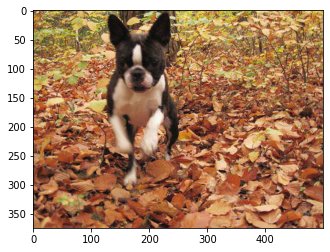

In [20]:
import matplotlib.pyplot as plt
from matplotlib import image
img=image.imread("/content/drive/My Drive/Colab_Notebooks/practice/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")
plt.imshow(img)

### Preprocessing Images
1. Process the images: Turning Images into Tensors
  * Convert into tensor doc string
  * Decode the doc string
  * Regularization (Make values 0-1) us astype(float32)
  * Resize the tensor to standard (eg: 224/224 )
2. Create Train and validation batches
  * Make images into batches of 32 sets each
  * Make a function, shuffle values in train sets

#### All the above steps can be done using generator as below

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base='/content/drive/My Drive/Colab_Notebooks/practice/dog-breed-identification/train'
def generate_data(im_size=224):
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2)
    valid_datagen = ImageDataGenerator(rescale=1./255.)

    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory=base,
                                                  x_col='id',
                                                  y_col='breed',
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  target_size=(im_size, im_size))

    valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_valid,
                                                 directory=base,
                                                 x_col='id',
                                                 y_col='breed',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 target_size=(im_size,im_size))
    return train_generator,valid_generator

In [22]:
train_generator,valid_generator=generate_data()

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


## Transfer Learning

## Checking the best Transfer Learning model;
* Model 1: MobileNetV2
* Model 2: ResnetV2
* Model 3: InceptionResnetV2

In [23]:
tf.keras.backend.clear_session()
model_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
import tensorflow_hub as hub

model_1=tf.keras.Sequential([hub.KerasLayer(model_url),
                            tf.keras.layers.Dense(512,activation='relu',kernel_initializer ='glorot_normal'),
                            tf.keras.layers.Dropout(0.1),
                            tf.keras.layers.BatchNormalization(momentum=0.9),
                            tf.keras.layers.Dense(units=120,activation='softmax')])
model_1.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
INPUT_SHAPE=[None,224,224,3]
model_1.build(input_shape=INPUT_SHAPE)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  513024    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  2048      
_________________________________________________________________
dense_1 (Dense)              multiple                  61560     
Total params: 6,009,345
Trainable params: 575,608
Non-trainable params: 5,433,737
_________________________________________________________________


In [24]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.models import Model

#with strategy.scope():
pre_trained=ResNet152V2(include_top=True, weights='imagenet')

for layer in pre_trained.layers:
    layer.trainable=False

out=pre_trained.output
x=tf.keras.layers.Dense(512,activation='relu',kernel_initializer='glorot_normal')(out)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x=tf.keras.layers.Dense(units=120,activation='softmax')(x)

model_2=Model(pre_trained.input,x)

model_2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [25]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model

#with strategy.scope():
pre_trained=InceptionResNetV2(include_top=True, weights='imagenet')

for layer in pre_trained.layers:
    layer.trainable=False

out=pre_trained.output
x=tf.keras.layers.Dense(512,activation='relu',kernel_initializer='glorot_normal')(out)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x=tf.keras.layers.Dense(units=120,activation='softmax')(x)

model_3=Model(pre_trained.input,x)

model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [26]:
history_1=[]
history_2=[]
history_3=[]
models=[model_1,model_2,model_3]
histories=[history_1,history_2,history_3]
for i in range(3):
    histories[i]=models[i].fit(train_generator,
                               validation_data=valid_generator,
                               epochs=20,
                               steps_per_epoch=10,
                               validation_steps=5)

Epoch 1/20
10/10 [==============================] - 28s 3s/step - loss: 4.7572 - accuracy: 0.1031 - val_loss: 3.6880 - val_accuracy: 0.2937
Epoch 2/20
10/10 [==============================] - 32s 3s/step - loss: 3.4090 - accuracy: 0.2500 - val_loss: 2.6203 - val_accuracy: 0.3438
Epoch 3/20
10/10 [==============================] - 31s 3s/step - loss: 2.6988 - accuracy: 0.3562 - val_loss: 2.1562 - val_accuracy: 0.4812
Epoch 4/20
10/10 [==============================] - 37s 4s/step - loss: 2.1979 - accuracy: 0.4938 - val_loss: 1.6219 - val_accuracy: 0.5562
Epoch 5/20
10/10 [==============================] - 27s 3s/step - loss: 1.8994 - accuracy: 0.5000 - val_loss: 1.3854 - val_accuracy: 0.6500
Epoch 6/20
10/10 [==============================] - 32s 3s/step - loss: 1.4551 - accuracy: 0.6469 - val_loss: 1.2011 - val_accuracy: 0.6250
Epoch 7/20
10/10 [==============================] - 32s 3s/step - loss: 1.6087 - accuracy: 0.5875 - val_loss: 1.0344 - val_accuracy: 0.7000
Epoch 8/20
10/10 [==

In [27]:
history_1,history_2,history_3=histories

print(f"Model_1 : MobileNetV2 \n Training_accuracy : {round(history_1.history['accuracy'][-1]*100,2)}%\n Validation accuracy : {round(history_1.history['val_accuracy'][-1]*100,2)}%\n\n")
print(f"Model_2 : ResNet152V2 \n Training_accuracy : {round(history_2.history['accuracy'][-1]*100,2)}%\n Validation accuracy : {round(history_2.history['val_accuracy'][-1]*100,2)}%\n\n")
print(f"Model_3 : InceptionResNetV2 \n Training_accuracy : {round(history_3.history['accuracy'][-1]*100,2)}%\n Validation accuracy : {round(history_3.history['val_accuracy'][-1]*100,2)}%\n\n")

Model_1 : MobileNetV2 
 Training_accuracy : 68.12%
 Validation accuracy : 77.5%


Model_2 : ResNet152V2 
 Training_accuracy : 73.44%
 Validation accuracy : 75.63%


Model_3 : InceptionResNetV2 
 Training_accuracy : 78.12%
 Validation accuracy : 86.25%




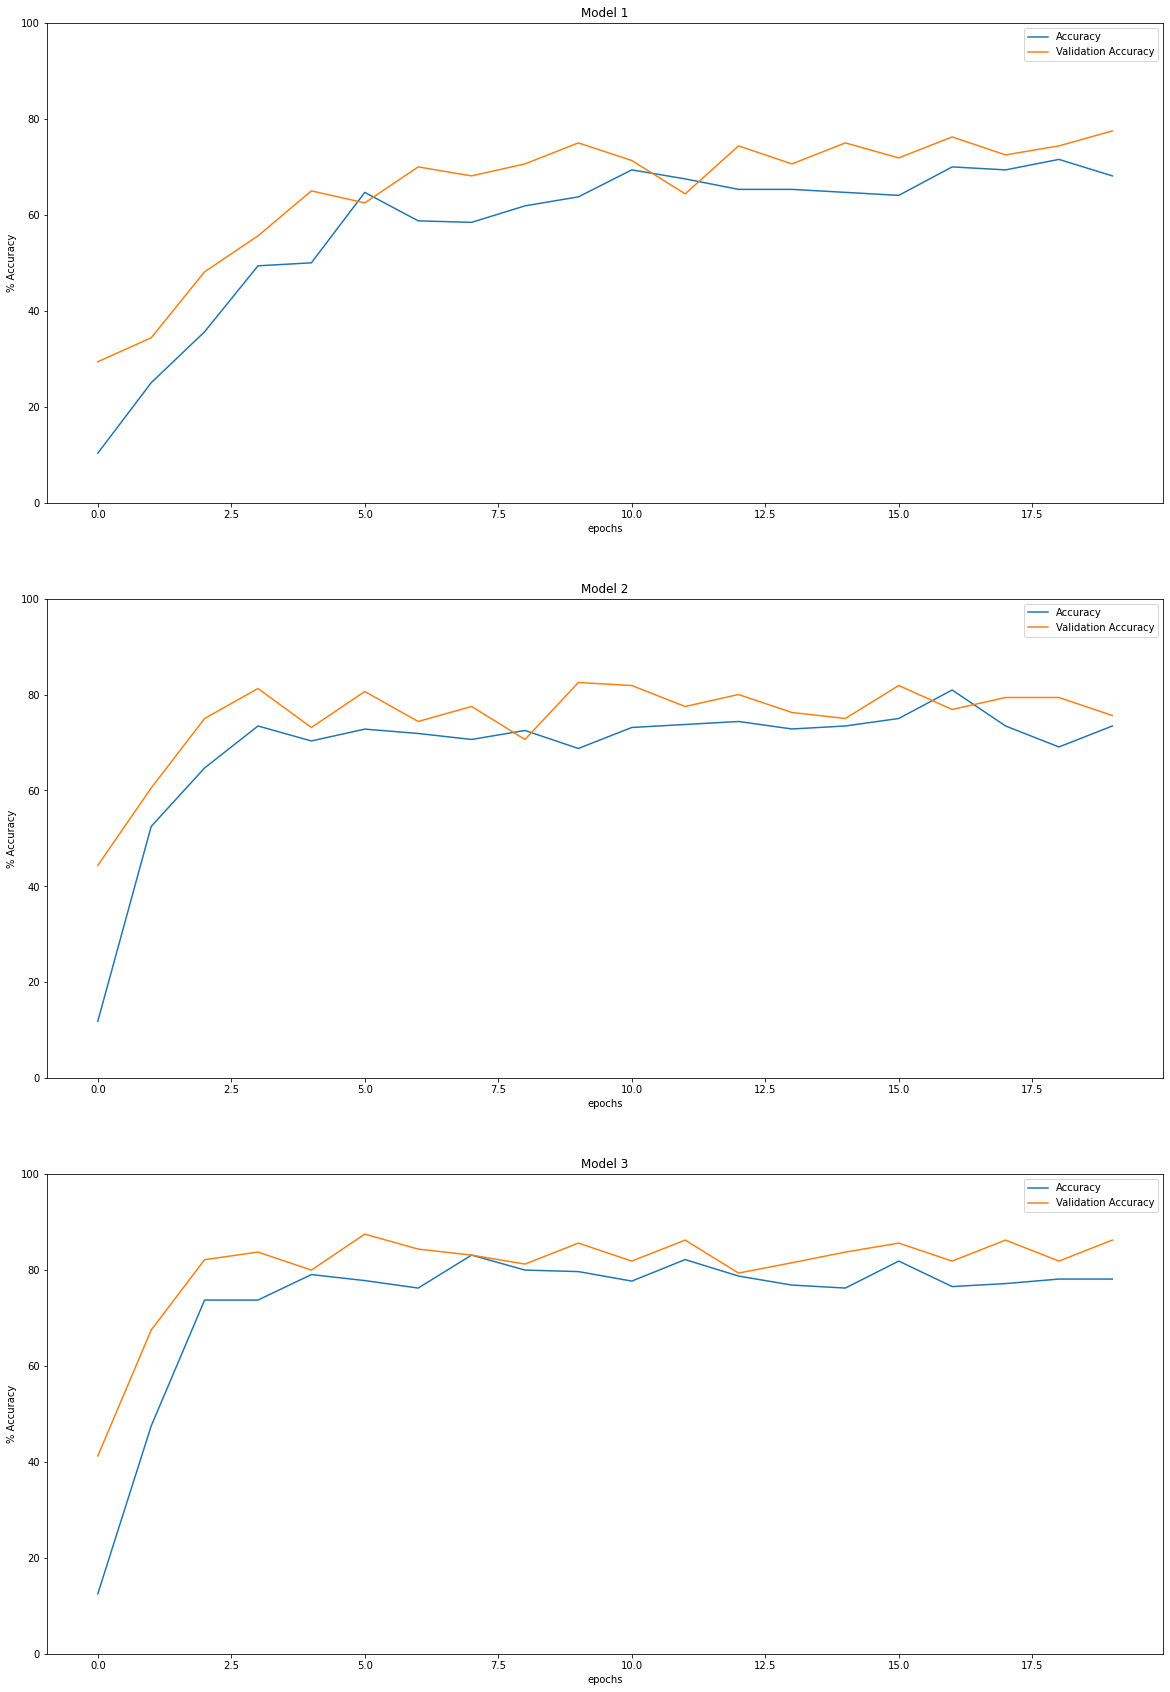

In [29]:
epochs=np.arange(len(histories[0].history['accuracy']))
import matplotlib.pyplot as plt
#plt.plot(epochs,history_1.history['accuracy'])
fig,ax=plt.subplots(3,figsize=[20,30])
for i in range(3):
    ax[i].plot(epochs,np.array(histories[i].history['accuracy'])*100,label='Accuracy')
    ax[i].plot(epochs,np.array(histories[i].history['val_accuracy'])*100,label='Validation Accuracy')
    ax[i].legend()
    ax[i].set(ylim=(0, 100),
               xlabel='epochs', ylabel='% Accuracy',
               title='Model '+str(i+1))

### From the comparsion InceptionResnetV2 works best.
* Improve model 3
* Train the last layers in the transfer learning model.
* It will help improve the identification of different features of various dogs

In [34]:
tf.keras.backend.clear_session()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
pre_model=InceptionResNetV2(include_top=True,weights='imagenet')

trigger=0
for layer in pre_model.layers:
    if layer==pre_model.get_layer('conv_7b'):
        trigger=1
    if trigger==0:
        layer.trainable=False
    if trigger==1:
        layer.trainable=True
  
out=pre_model.output
x=tf.keras.layers.BatchNormalization()(out)
x=tf.keras.layers.Dense(120,activation='softmax',kernel_initializer='glorot_uniform')(x)
with tf.device('/GPU:0'):
    model=Model(pre_model.input,x)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
## Create Custom CallBacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.97) and (logs.get('val_accuracy')<0.80):
            print('\nModel is overfitting hence stopped training')
            self.model.stop_training=True
        if(logs.get('accuracy')>0.98) and (logs.get('val_accuracy')>0.98):
            print('\nModel is accurate hence stopped training')
            self.model.stop_training=True
        
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [36]:
history=model.fit(train_generator,
                  validation_data=valid_generator,
                  epochs=100,
                  steps_per_epoch=100,
                  validation_steps=50,
                  callbacks=[myCallback(),early_stopping])

Epoch 1/100
100/100 [==============================] - 60s 600ms/step - loss: 4.2708 - accuracy: 0.2867 - val_loss: 4.6305 - val_accuracy: 0.2392
Epoch 2/100
100/100 [==============================] - 57s 575ms/step - loss: 3.0619 - accuracy: 0.6231 - val_loss: 4.3336 - val_accuracy: 0.5956
Epoch 3/100
100/100 [==============================] - 57s 575ms/step - loss: 2.1213 - accuracy: 0.6963 - val_loss: 3.8002 - val_accuracy: 0.7182
Epoch 4/100
100/100 [==============================] - 57s 566ms/step - loss: 1.4774 - accuracy: 0.7394 - val_loss: 2.9221 - val_accuracy: 0.7890
Epoch 5/100
100/100 [==============================] - 57s 570ms/step - loss: 1.1827 - accuracy: 0.7566 - val_loss: 1.9080 - val_accuracy: 0.8053
Epoch 6/100
100/100 [==============================] - 57s 568ms/step - loss: 1.0741 - accuracy: 0.7625 - val_loss: 1.1554 - val_accuracy: 0.7984
Epoch 7/100
100/100 [==============================] - 57s 571ms/step - loss: 0.9034 - accuracy: 0.7953 - val_loss: 0.8460 -